<a href="https://colab.research.google.com/github/Madhu3456/IITISoC-22-AI-ML-11-Song-Recommendation/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import keras
import os
import sys
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LeakyReLU
import cv2
import keras.backend as K

Read data from G-drive

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


To check if the dataset is empty

In [ ]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

*Data PreProcessing*

Shuffle data

In [ ]:
df = df.sample(frac=1)

Changing image pixels to Numpy array

In [ ]:
train_pixels = df["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

Standardization

In [ ]:
pixels = train_pixels.reshape((35887*2304,1))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [ ]:
pixels = train_pixels.reshape((35887, 48, 48,1))

Illumination Normalisation

In [ ]:
def normalize(img):
  lmin = float(img.min())
  lmax = float(img.max())
  return np.floor((img-lmin)/(lmax-lmin*255.0))

  for i in range(0,35887):
    df['pixels'][i] = normalize(df['pixels'][i] )

One Hot Encoding

In [ ]:
labels = to_categorical(df['emotion'], num_classes=7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixels,labels, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,shuffle=False)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

Data Augumentation

In [ ]:
train_datagen.fit(X_train)
valid_datagen.fit(X_val)

train_generator = train_datagen.flow(X_train, y_train,
                                                  batch_size=64)
val_generator = valid_datagen.flow(X_val, y_val,batch_size=64)



model

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

Model

In [ ]:
width,height = 48,48

In [ ]:

network = Sequential()

network.add(Conv2D(32, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 1)))
network.add(BatchNormalization())
network.add(Conv2D(64, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(128, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(128, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(256, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(256, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(512, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(512, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(512, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(512, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(7, activation='softmax'))

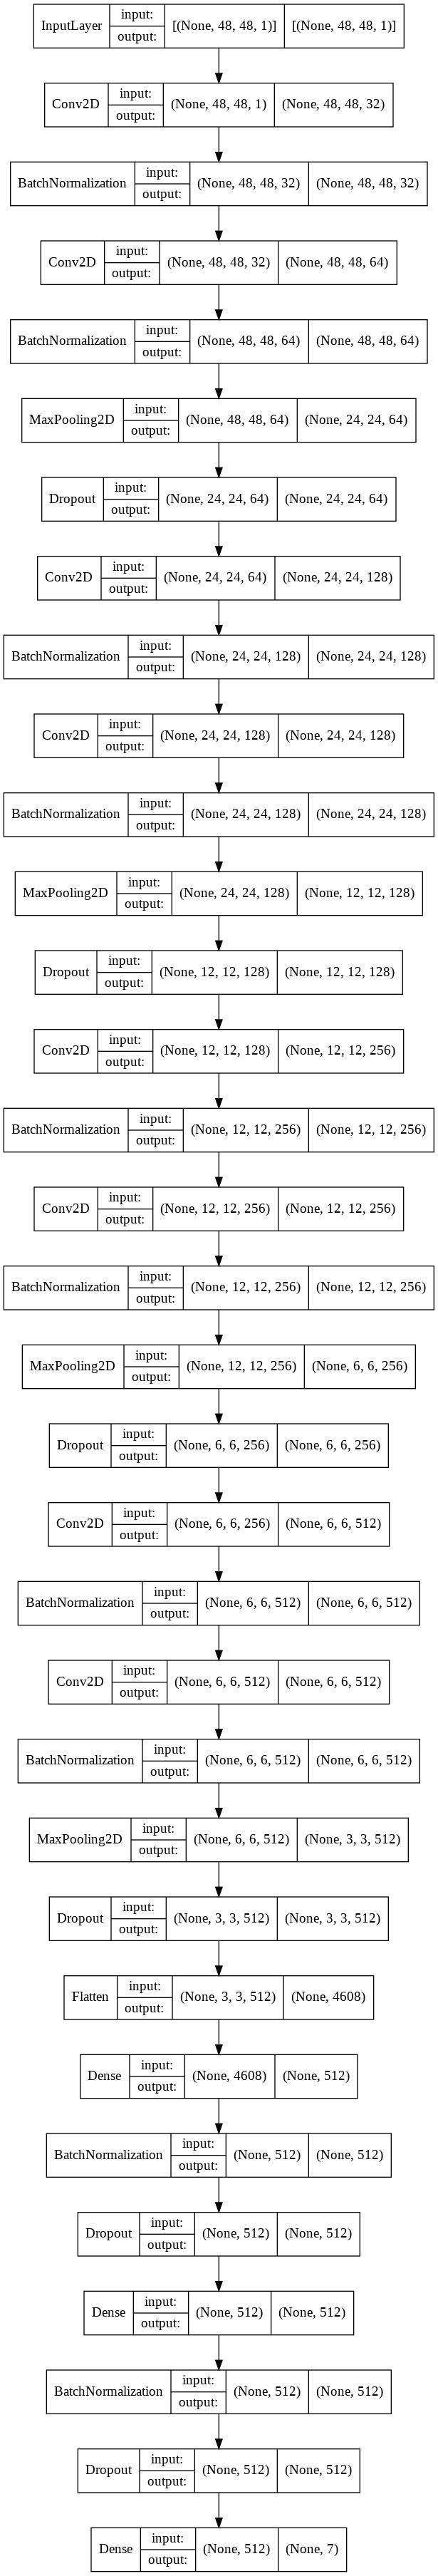

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(network, show_layer_names=False, show_shapes=True, to_file='model.png')

Early stopping to prevent overfitting

In [ ]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99,decay=0.001/32)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


compile model

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

Fit model

In [ ]:
history=network.fit(train_generator,epochs=5, callbacks=[lrd,mcp,es], verbose=2,validation_data=val_generator)

Epoch 1/5
359/359 - 18s - loss: 1.3665 - accuracy: 0.8795 - precision: 0.7165 - recall: 0.2585 - auc: 0.8364 - f1_score: 0.3786 - val_loss: 1.3786 - val_accuracy: 0.8747 - val_precision: 0.6122 - val_recall: 0.3346 - val_auc: 0.8405 - val_f1_score: 0.4308 - lr: 0.0010 - 18s/epoch - 51ms/step
Epoch 2/5
359/359 - 18s - loss: 1.2999 - accuracy: 0.8826 - precision: 0.7157 - recall: 0.2954 - auc: 0.8538 - f1_score: 0.4170 - val_loss: 1.9916 - val_accuracy: 0.8305 - val_precision: 0.3838 - val_recall: 0.3084 - val_auc: 0.7647 - val_f1_score: 0.3421 - lr: 0.0010 - 18s/epoch - 51ms/step
Epoch 3/5
359/359 - 18s - loss: 1.2510 - accuracy: 0.8859 - precision: 0.7197 - recall: 0.3295 - auc: 0.8654 - f1_score: 0.4508 - val_loss: 1.2261 - val_accuracy: 0.8868 - val_precision: 0.7342 - val_recall: 0.3251 - val_auc: 0.8706 - val_f1_score: 0.4483 - lr: 0.0010 - 18s/epoch - 50ms/step
Epoch 4/5
359/359 - 19s - loss: 1.2277 - accuracy: 0.8877 - precision: 0.7274 - recall: 0.3426 - auc: 0.8710 - f1_score: 

In [ ]:
network.save('emotions.h5')

In [ ]:
model = tf.keras.models.load_model('emotions.h5',custom_objects={"f1_score": f1_score })

In [ ]:
loss = network.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

225/225 [==============================] - 6s 17ms/step - loss: 33.2433 - accuracy: 0.7948 - precision: 0.2815 - recall: 0.2813 - auc: 0.5891 - f1_score: 0.2811
Test Acc: 0.794769823551178


Save model using pickle

In [ ]:
import pickle
with open('model.pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://0b201242-6c91-4795-84c4-d12d2f36a5b4/assets
